In [1]:
import os
import argparse
import socket
import copy

import pandas as pd
import numpy as np
import torch 
import tqdm
import matplotlib.pyplot as plt
from scipy.spatial import distance
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.manifold import TSNE

from braindecode.datasets.base import BaseConcatDataset
from braindecode.datasets import TUHAbnormal
from braindecode.preprocessing import create_fixed_length_windows
from braindecode.util import set_random_seeds
from braindecode.models.util import to_dense_prediction_model, get_output_shape
from braindecode.datasets.tuh import TUHAbnormal
from braindecode.preprocessing import preprocess, Preprocessor
from braindecode.datasets.base import BaseConcatDataset
from braindecode.preprocessing.windowers import create_fixed_length_windows
from braindecode.models import Deep4Net

from transformers import AutoTokenizer, AutoModel
from InstructorEmbedding import INSTRUCTOR

from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint

from EEGClip.classifier_models import EEGClassifierModel
from EEGClip.clip_models import EEGClipModel
from EEGClip.text_preprocessing import text_preprocessing

import mne
mne.set_log_level('ERROR')  # avoid messages everytime a window is extracted


import EEGClip_config

"""
This script uses EEG-Clip representations to do recording retrieval :
given a EEG segment, retrive the corresponding text description, and vice-versa
metrics : median rank, recall@k

"""


n_recordings_to_load = 2993


n_max_minutes = 3
sfreq = 100
n_minutes = 2
input_window_samples = 1200

batch_size = 64

nailcluster = (socket.gethostname() == "vs3-0")

num_workers = 16

results_dir = EEGClip_config.results_dir
tuh_data_dir = EEGClip_config.tuh_data_dir

# TODO : use get_output_shape (requires to load the model first)
n_preds_per_input = 519 #get_output_shape(eeg_classifier_model, n_chans, input_window_samples)[2]


seed = 20210325  # random seed to make results reproducible

cuda = torch.cuda.is_available()
set_random_seeds(seed=seed, cuda=cuda)
torch.backends.cudnn.benchmark = True

# ## Load data
dataset = TUHAbnormal(
    path=tuh_data_dir,
    recording_ids=range(n_recordings_to_load),  # loads the n chronologically first recordings
    target_name="report",  # age, gender, pathology
    preload=False,
    add_physician_reports=True,
    n_jobs=1)

dataset.set_description(text_preprocessing(dataset.description, processed_categories = "all"), overwrite=True)

# ## Preprocessing

ar_ch_names = sorted([
    'EEG A1-REF', 'EEG A2-REF',
    'EEG FP1-REF', 'EEG FP2-REF', 'EEG F3-REF', 'EEG F4-REF', 'EEG C3-REF',
    'EEG C4-REF', 'EEG P3-REF', 'EEG P4-REF', 'EEG O1-REF', 'EEG O2-REF',
    'EEG F7-REF', 'EEG F8-REF', 'EEG T3-REF', 'EEG T4-REF', 'EEG T5-REF',
    'EEG T6-REF', 'EEG FZ-REF', 'EEG CZ-REF', 'EEG PZ-REF'])

preprocessors = [
    Preprocessor(fn='pick_channels', ch_names=ar_ch_names, ordered=True),
    Preprocessor('crop', tmin=0, tmax=n_max_minutes*60, include_tmax=True),
    Preprocessor(fn=lambda x: np.clip(x, -800,800), apply_on_array=True),
    Preprocessor('set_eeg_reference', ref_channels='average'),
    # convert from volt to microvolt, directly modifying the numpy array
    Preprocessor(fn=lambda x: x * 1e6, apply_on_array=True),
    Preprocessor(fn=lambda x: x / 30, apply_on_array=True), # this seemed best
    Preprocessor(fn='resample', sfreq=sfreq),
]
# Preprocess the data
if not nailcluster:
    preprocess(dataset, preprocessors)

# ## Data Splitting
# TODO : split using train and test splits instead
# TODO : maybe load TUH now on top of TUH Abnormal ?


#dataset = dataset.split('train')['True']

n_subjects = len(dataset.split('subject'))

print("Nb subjects loaded : ", n_subjects)

valid_set = dataset.split('train')['False']


window_valid_set = create_fixed_length_windows(
    valid_set,
    start_offset_samples=60*sfreq,
    stop_offset_samples=60*sfreq+n_minutes*60*sfreq,
    preload=True,
    window_size_samples=input_window_samples,
    window_stride_samples=n_preds_per_input,
    drop_last_window=False,
)

### PREPROCESSING NECESSARY IF USING TUH_PRE
if nailcluster:

    window_valid_set.transform = lambda x: x*1e6

valid_loader = torch.utils.data.DataLoader(
    window_valid_set,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    drop_last=False)

print(len(valid_loader.dataset))


# ## Create model

eegclipmodel = EEGClipModel.load_from_checkpoint(EEGClip_config.model_paths["eegclip"])
eegclipmodel.cuda()
EEGEncoder = torch.nn.Sequential(eegclipmodel.eeg_encoder,eegclipmodel.eeg_projection)
# get size of the last layer
text_encoder_name = "medicalai/ClinicalBERT"


for param in EEGEncoder.parameters():
    param.requires_grad = False

embs_df = pd.read_csv(EEGClip_config.embs_df_path)
embs_name = text_encoder_name
for r in range(len(embs_df)):
    re = copy.copy(embs_df[embs_name][r])
    # convert the string to array
    re = re.replace('[', '')
    re = re.replace(']', '')
    re = re.replace(',', '')
    re = re.split()
    re = [float(i) for i in re]
    embs_df[embs_name][r] = re
# iterate over the validation set and get the embeddings
eeg_embs = []
text_embs = []
for batch in tqdm.tqdm(valid_loader):
    eeg, text, id = batch
    eeg = eeg.cuda()
    eeg = EEGEncoder(eeg)
    eeg = torch.mean(eeg, dim=2)
    eeg_embs.append(eeg.detach().cpu().numpy())

    text_emb = []
    for s in text:
        lookup = embs_df.loc[embs_df['report'] == s, text_encoder_name]
        
        emb = lookup.tolist()[0]
        text_emb.append(emb)
    text_emb = torch.Tensor(text_emb).to(device='cuda:0')
    text_emb = eegclipmodel.text_projection(text_emb) #somehow, projecting the embeddings cause them to be unique 
    # (floating point precision ?) So we cannot use them to identify the recordings of each batch element (see below for that)
    text_embs.append(text_emb.detach().cpu().numpy())


eeg_embs = np.concatenate(eeg_embs)
text_embs = np.concatenate(text_embs)

print(eeg_embs.shape)
print(text_embs.shape)

/home/jovyan/test_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jovyan/test_env/lib/python3.10/site-packages/braindecode/preprocessing/preprocess.py:55: UserWarning: Preprocessing choices with lambda functions cannot be saved.
  warn('Preprocessing choices with lambda functions cannot be saved.')


Nb subjects loaded :  2329


/home/jovyan/test_env/lib/python3.10/site-packages/braindecode/preprocessing/windowers.py:608: UserWarning: Usage of offset_sample args in create_fixed_length_windows is deprecated and will be removed in future versions. Please use braindecode.preprocessing.preprocess.Preprocessor("crop", tmin, tmax) instead.
  warnings.warn('Usage of offset_sample args in create_fixed_length_windows is deprecated and'


6072


/home/jovyan/EEGClip/EEGClip/clip_models.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  embs_df[embs_name][r] = re
/tmp/ipykernel_3149/160036150.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  embs_df[embs_name][r] = re
100%|██████████| 95/95 [00:09<00:00,  9.82it/s]

(6072, 64)
(6072, 64)


In [20]:
# identify the recordings of each batch element 
t = []
for batch in valid_loader:
    eeg, text, id = batch
    t.append(text)

t = np.concatenate(t)


e = []
for s in t:
        lookup = embs_df.loc[embs_df['report'] == s, text_encoder_name]
        
        emb = lookup.tolist()[0]
        e.append(emb)

n_recordings = eeg_embs.shape[0] 
unique_rows = np.unique(e, axis=0)

# Get unique rows 

# Create mapping of recording index to unique ID
unique_ids = np.zeros(n_recordings, dtype=int)
for i, row in enumerate(e):
    unique_ids[i] = np.where(np.all(unique_rows == row, axis=1))[0][0]

print(unique_ids)

275

In [39]:
from sklearn.metrics.pairwise import cosine_similarity

n_recordings = eeg_embs.shape[0] 

retrieval_acc = []

for i in range(n_recordings):

  eeg_emb = eeg_embs[i]
  true_id = unique_ids[i]

  # Get embeddings for true patient  
  true_indices = np.where(unique_ids == true_id)[0]
  text_true = text_embs[true_indices]

  sims = cosine_similarity(eeg_emb.reshape(1,-1), text_embs)[0]
  retrieved_id = unique_ids[np.argmax(sims)]

  correct = (retrieved_id == true_id)
  retrieval_acc.append(correct)

print("Patient Retrieval Accuracy:", np.mean(retrieval_acc))

Patient Retrieval Accuracy: 0.030467720685111988


In [41]:
ranks = []
for i in range(n_recordings):

  eeg_emb = eeg_embs[i]
  true_id = unique_ids[i]  

  sims = cosine_similarity(eeg_emb.reshape(1,-1), text_embs)[0]
  sorted_ids = unique_ids[np.argsort(sims)[::-1]]

  true_idx = np.where(sorted_ids == true_id)[0][0]
  ranks.append(true_idx + 1) 

median_rank = np.median(ranks)
print("Median rank for text retrieval:", median_rank)

Median Patient Rank: 548.0


In [47]:
ranks = []
for i in range(n_recordings):

  text_emb = text_embs[i]
  true_id = unique_ids[i]  

  sims = cosine_similarity(text_emb.reshape(1,-1), eeg_embs)[0]
  sorted_ids = unique_ids[np.argsort(sims)[::-1]]

  true_idx = np.where(sorted_ids == true_id)[0][0]
  ranks.append(true_idx + 1) 

median_rank = np.median(ranks)
print("Median rank for eeg retrieval:", median_rank)

Median rank for eeg retrieval: 166.0


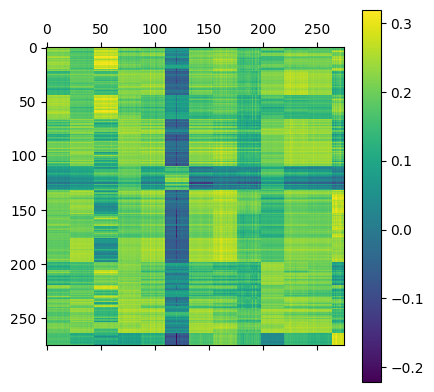

In [49]:
unique_ids = np.unique(unique_ids)
num_patients = len(unique_ids)

# Initialize random index vector  
random_idx = np.zeros(num_patients, dtype=int)

for i in range(num_patients):
  
  pid = unique_ids[i] 
  indices = np.where(unique_ids == pid)[0]
  random_idx[i] = np.random.choice(indices)

# Construct similarity matrix  
sim_matrix = np.zeros((num_patients, num_patients))

for i in range(num_patients):
  eeg_idx = random_idx[i]
  for j in range(num_patients):
    text_idx = random_idx[j]
    
    eeg1 = eeg_embs[eeg_idx].reshape(1,-1)
    text2 = text_embs[text_idx].reshape(1,-1)  
    sim = cosine_similarity(eeg1, text2)
      
    sim_matrix[i,j] = sim


# Plot heatmap
plt.matshow(sim_matrix)
plt.colorbar() 
plt.show()